# Specific Test V. Exploring Transformers

> Three different transformer models were used for this test. This notebook contains the results of the CvT model

**Task:** Use a vision transformer method of your choice to build a robust and efficient model for binary classification or unsupervised anomaly detection on the provided dataset. In the case of unsupervised anomaly detection, train your model to learn the distribution of the provided strong lensing images with no substructure. Please implement your approach in PyTorch or Keras and discuss your strategy.

**Dataset Description:** A set of simulated strong gravitational lensing images with and without substructure. 

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)

## Strategy



A CvT modified version of model from [vit-pytorch](https://github.com/lucidrains/vit-pytorch#cvt) was used for in this test. The model was trained for 30 epochs with an initial learning rate of 0.0001 and a batch size of 64. The scheduler used was CosineAnnealingLR with with a minimum learning rate of 0.000001. the criterion used was CrossEntropyLoss

The dataset is split in a 9:1 train-test ratio. The training set is resized to 256*256 image and augmented using ColorJitter, RandomHorizontalFlip and RandomRotation. The test set is only resized and not augmented.

## Results

**ROC-AUC Score:** 0.99992

**Training Curve:**

![Training Curve](../results/test-5-cvt-training-plot.png)

**ROC Curve:**

![ROC Curve](../results/test-5-cvt-roc-plot.png)

In [27]:
!pip install einops

In [28]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading Data

In [29]:
base_dir = '/kaggle/input/ml4sci-test5/lenses'

train_df = pd.DataFrame(columns = ['path', 'label'])

label_map = {'no_sub':0, 'sub':1}
val_label_map = {0:'no_sub', 1:'sub'}

for i in label_map.keys():
    entries = [os.path.join(base_dir, i, j) for j in os.listdir(os.path.join(base_dir, i))]
    temp_df = pd.DataFrame({'path':entries, 'label':i})
    train_df = pd.concat([train_df, temp_df], ignore_index=True)

train_df.head()

,path,label
0,/kaggle/input/ml4sci-test5/lenses/no_sub/image...,no_sub
1,/kaggle/input/ml4sci-test5/lenses/no_sub/image...,no_sub
2,/kaggle/input/ml4sci-test5/lenses/no_sub/image...,no_sub
3,/kaggle/input/ml4sci-test5/lenses/no_sub/image...,no_sub
4,/kaggle/input/ml4sci-test5/lenses/no_sub/image...,no_sub


In [30]:
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

print(f"Train split:\n{train_df['label'].value_counts()}\n")
print(f"Test split:\n{test_df['label'].value_counts()}")

Train split:
sub       4500
no_sub    4500
Name: label, dtype: int64

Test split:
sub       500
no_sub    500
Name: label, dtype: int64


In [31]:
class Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)

        label = self.df.iloc[idx]['label']
        label = label_map[label]
        
        return img, label

In [32]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(256),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

train_dataset = Dataset(train_df, transform=train_transforms)
test_dataset = Dataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

In [33]:
img, label = next(iter(train_loader))
print(img.shape)

torch.Size([64, 1, 256, 256])


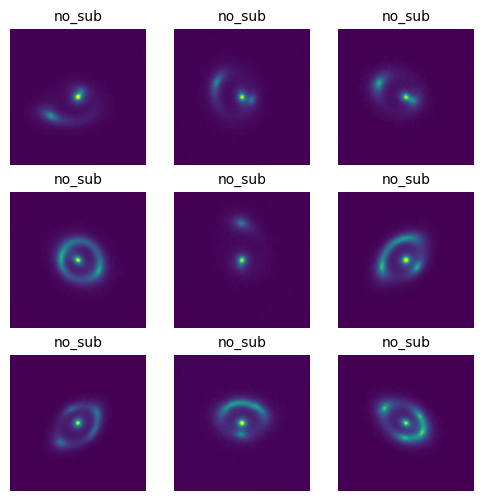

In [34]:
def show_batch(images, labels, class_map):
    fig, ax = plt.subplots(3, 3, figsize=(6, 6))
    for i in range(3):
        for j in range(3):
            image = images[i*3 + j]
            label = torch.argmax(labels[i*3 + j])
            ax[i][j].imshow(image.permute(1, 2, 0))
            title = [k for k, v in class_map.items() if v == label][0]
            ax[i][j].set_title(title)
            ax[i][j].axis('off')
            ax[i][j].title.set_fontsize(10)

    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, label_map)

## Defining Model

In [35]:
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange
from einops.layers.torch import Rearrange

# helper methods

def group_dict_by_key(cond, d):
    return_val = [dict(), dict()]
    for key in d.keys():
        match = bool(cond(key))
        ind = int(not match)
        return_val[ind][key] = d[key]
    return (*return_val,)

def group_by_key_prefix_and_remove_prefix(prefix, d):
    kwargs_with_prefix, kwargs = group_dict_by_key(lambda x: x.startswith(prefix), d)
    kwargs_without_prefix = dict(map(lambda x: (x[0][len(prefix):], x[1]), tuple(kwargs_with_prefix.items())))
    return kwargs_without_prefix, kwargs

# classes

class LayerNorm(nn.Module): # layernorm, but done in the channel dimension #1
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) / (var + self.eps).sqrt() * self.g + self.b

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        x = self.norm(x)
        return self.fn(x, **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim, dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(dim * mult, dim, 1),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class DepthWiseConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding, stride, bias = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size = kernel_size, padding = padding, groups = dim_in, stride = stride, bias = bias),
            nn.BatchNorm2d(dim_in),
            nn.Conv2d(dim_in, dim_out, kernel_size = 1, bias = bias)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, proj_kernel, kv_proj_stride, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        padding = proj_kernel // 2
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_q = DepthWiseConv2d(dim, inner_dim, proj_kernel, padding = padding, stride = 1, bias = False)
        self.to_kv = DepthWiseConv2d(dim, inner_dim * 2, proj_kernel, padding = padding, stride = kv_proj_stride, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(inner_dim, dim, 1),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        shape = x.shape
        b, n, _, y, h = *shape, self.heads
        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = 1))
        q, k, v = map(lambda t: rearrange(t, 'b (h d) x y -> (b h) (x y) d', h = h), (q, k, v))

        dots = einsum('b i d, b j d -> b i j', q, k) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) (x y) d -> b (h d) x y', h = h, y = y)
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, proj_kernel, kv_proj_stride, depth, heads, dim_head = 64, mlp_mult = 4, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, proj_kernel = proj_kernel, kv_proj_stride = kv_proj_stride, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_mult, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class CvT(nn.Module):
    def __init__(
        self,
        *,
        num_classes,
        s1_emb_dim = 64,
        s1_emb_kernel = 7,
        s1_emb_stride = 4,
        s1_proj_kernel = 3,
        s1_kv_proj_stride = 2,
        s1_heads = 1,
        s1_depth = 1,
        s1_mlp_mult = 4,
        s2_emb_dim = 192,
        s2_emb_kernel = 3,
        s2_emb_stride = 2,
        s2_proj_kernel = 3,
        s2_kv_proj_stride = 2,
        s2_heads = 3,
        s2_depth = 2,
        s2_mlp_mult = 4,
        s3_emb_dim = 384,
        s3_emb_kernel = 3,
        s3_emb_stride = 2,
        s3_proj_kernel = 3,
        s3_kv_proj_stride = 2,
        s3_heads = 6,
        s3_depth = 10,
        s3_mlp_mult = 4,
        dropout = 0.
    ):
        super().__init__()
        kwargs = dict(locals())

        dim = 1
        layers = []

        for prefix in ('s1', 's2', 's3'):
            config, kwargs = group_by_key_prefix_and_remove_prefix(f'{prefix}_', kwargs)

            layers.append(nn.Sequential(
                nn.Conv2d(dim, config['emb_dim'], kernel_size = config['emb_kernel'], padding = (config['emb_kernel'] // 2), stride = config['emb_stride']),
                LayerNorm(config['emb_dim']),
                Transformer(dim = config['emb_dim'], proj_kernel = config['proj_kernel'], kv_proj_stride = config['kv_proj_stride'], depth = config['depth'], heads = config['heads'], mlp_mult = config['mlp_mult'], dropout = dropout)
            ))

            dim = config['emb_dim']

        self.layers = nn.Sequential(*layers)

        self.to_logits = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            Rearrange('... () () -> ...'),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        latents = self.layers(x)
        return self.to_logits(latents)

## Hyper-parameters and Training

In [36]:
def train(model, epochs, optimizer, criterion, scheduler, device, trainloader, testloader):

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
        
    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        best_acc = 0.0
        
        print(f"Epoch: {i + 1}")
        
        for images, targets in tqdm(trainloader, desc= "Train\t"):
            
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
        
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)

        scheduler.step()
        
        train_losses.append(running_loss / len(trainloader))
        train_acc.append(running_correct / total)

        running_val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():

            for images, targets in tqdm(testloader, desc= "Test\t"):
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                correct += (preds == targets).sum().item()
                running_val_loss += criterion(output, targets).item()
                total += targets.size(0)

            acc = correct / total
            test_acc.append(acc)
            test_losses.append(running_val_loss / len(testloader))

        if test_acc[-1] > best_acc:
            best_acc = test_acc[-1]
            torch.save(model.state_dict(), 'best_model.pth') 

        print(f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}, Test Acc: {test_acc[-1]:.3f}\n")

    return train_losses, train_acc, test_losses, test_acc, best_acc

In [37]:
model = CvT(num_classes= 2, dropout= 0.1).to(device)

epochs = 30
lr = 0.0001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.000001)

In [38]:
train_losses, train_acc, test_losses, test_acc, best_acc = train(model, epochs, optimizer, loss_function, scheduler, device, train_loader, test_loader)

Epoch: 1


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Train Loss: 0.692, Train Acc: 0.623, Test Loss: 0.377, Test Acc: 0.782

Epoch: 2


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Train Loss: 0.368, Train Acc: 0.806, Test Loss: 0.261, Test Acc: 0.866

Epoch: 3


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Train Loss: 0.304, Train Acc: 0.843, Test Loss: 0.257, Test Acc: 0.880

Epoch: 4


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]


Train Loss: 0.258, Train Acc: 0.877, Test Loss: 0.201, Test Acc: 0.905

Epoch: 5


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]


Train Loss: 0.229, Train Acc: 0.893, Test Loss: 0.188, Test Acc: 0.915

Epoch: 6


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Train Loss: 0.177, Train Acc: 0.920, Test Loss: 0.143, Test Acc: 0.942

Epoch: 7


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Train Loss: 0.161, Train Acc: 0.929, Test Loss: 0.142, Test Acc: 0.939

Epoch: 8


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]


Train Loss: 0.138, Train Acc: 0.939, Test Loss: 0.190, Test Acc: 0.907

Epoch: 9


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]


Train Loss: 0.129, Train Acc: 0.945, Test Loss: 0.093, Test Acc: 0.962

Epoch: 10


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]


Train Loss: 0.121, Train Acc: 0.950, Test Loss: 0.092, Test Acc: 0.966

Epoch: 11


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]


Train Loss: 0.104, Train Acc: 0.957, Test Loss: 0.066, Test Acc: 0.978

Epoch: 12


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]


Train Loss: 0.105, Train Acc: 0.955, Test Loss: 0.060, Test Acc: 0.974

Epoch: 13


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]


Train Loss: 0.087, Train Acc: 0.965, Test Loss: 0.050, Test Acc: 0.983

Epoch: 14


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Train Loss: 0.078, Train Acc: 0.969, Test Loss: 0.057, Test Acc: 0.979

Epoch: 15


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]


Train Loss: 0.080, Train Acc: 0.968, Test Loss: 0.043, Test Acc: 0.986

Epoch: 16


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]


Train Loss: 0.072, Train Acc: 0.971, Test Loss: 0.055, Test Acc: 0.978

Epoch: 17


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Train Loss: 0.069, Train Acc: 0.972, Test Loss: 0.071, Test Acc: 0.967

Epoch: 18


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Train Loss: 0.060, Train Acc: 0.973, Test Loss: 0.039, Test Acc: 0.987

Epoch: 19


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Train Loss: 0.053, Train Acc: 0.977, Test Loss: 0.037, Test Acc: 0.987

Epoch: 20


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]


Train Loss: 0.062, Train Acc: 0.976, Test Loss: 0.049, Test Acc: 0.983

Epoch: 21


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]


Train Loss: 0.048, Train Acc: 0.982, Test Loss: 0.037, Test Acc: 0.983

Epoch: 22


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]


Train Loss: 0.047, Train Acc: 0.981, Test Loss: 0.022, Test Acc: 0.989

Epoch: 23


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]


Train Loss: 0.038, Train Acc: 0.985, Test Loss: 0.023, Test Acc: 0.992

Epoch: 24


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Train Loss: 0.038, Train Acc: 0.985, Test Loss: 0.031, Test Acc: 0.989

Epoch: 25


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Train Loss: 0.037, Train Acc: 0.985, Test Loss: 0.022, Test Acc: 0.992

Epoch: 26


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]


Train Loss: 0.037, Train Acc: 0.985, Test Loss: 0.028, Test Acc: 0.989

Epoch: 27


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]


Train Loss: 0.034, Train Acc: 0.987, Test Loss: 0.020, Test Acc: 0.991

Epoch: 28


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]


Train Loss: 0.028, Train Acc: 0.991, Test Loss: 0.023, Test Acc: 0.990

Epoch: 29


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Train Loss: 0.031, Train Acc: 0.987, Test Loss: 0.018, Test Acc: 0.995

Epoch: 30


Test	: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]


Train Loss: 0.027, Train Acc: 0.991, Test Loss: 0.021, Test Acc: 0.990



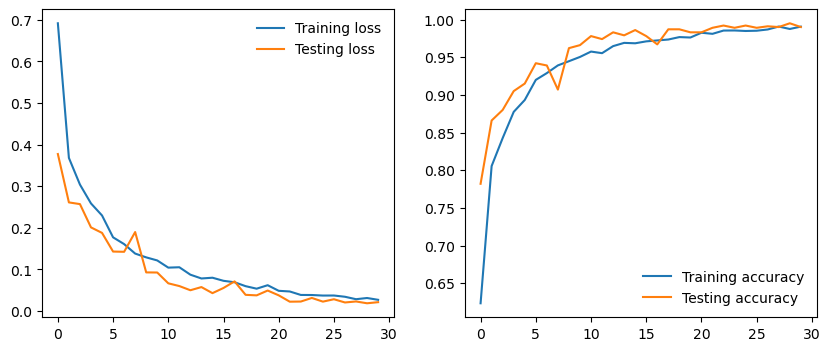

In [39]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training accuracy')
plt.plot(test_acc, label='Testing accuracy')
plt.legend(frameon=False)

## Testing

The best model is loaded for testing and the results are plotted.

In [40]:
model = CvT(num_classes= 2, dropout= 0.1).to(device)
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [41]:
y_true = []
y_pred_class = []
y_pred_prob = []

with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images, targets = images.to(device), targets.to(device)
        output = model(images)
        preds = torch.argmax(output, dim=1)
        y_true.extend(targets.cpu().numpy())
        y_pred_class.extend(preds.cpu().numpy())
        y_pred_prob.extend(output.cpu().numpy())

100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


In [42]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, auc

print(classification_report(y_true, y_pred_class, target_names=label_map.keys()))

              precision    recall  f1-score   support

      no_sub       0.99      1.00      0.99       500
         sub       1.00      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



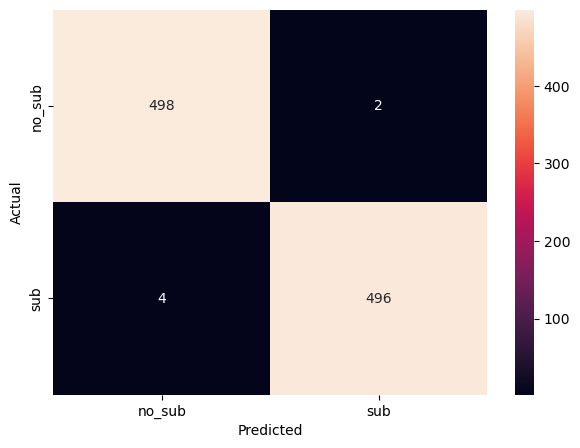

In [43]:
conf_matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [44]:
print(f"ROC-AUC Score: {roc_auc_score(y_true, np.array(y_pred_prob)[:,1], multi_class='ovr')}")

ROC-AUC Score: 0.99992


no_sub   ROC-AUC: 0.999888
sub      ROC-AUC: 0.99992


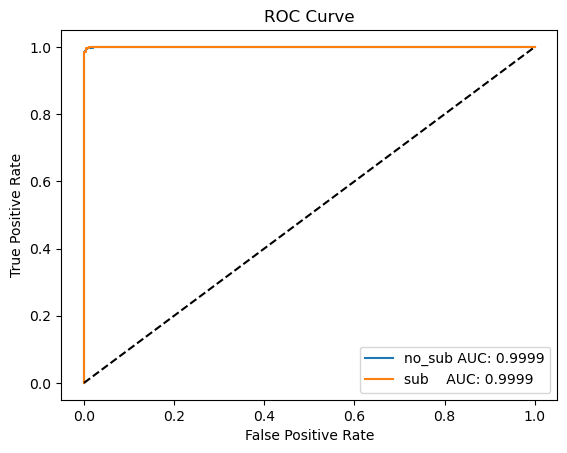

In [45]:
y_true_dummies = pd.get_dummies(y_true).values

auc_scores = {}
for i in range(2):
    fpr_i, tpr_i, thresholds_i = roc_curve(y_true_dummies[:, i], np.array(y_pred_prob)[:, i])
    auc_score = auc(fpr_i, tpr_i)
    print(f"{(val_label_map[i]).ljust(8)} ROC-AUC: {auc_score}")
    auc_scores[val_label_map[i]] = auc_score
    plt.plot(fpr_i, tpr_i, label=f"{(val_label_map[i]).ljust(6)} AUC: {auc_score:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()